In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

In [2]:
file_path = './_raw_yt_metadata.jsonl'
chunk_size = 100000

chunks = []

for chunk in pd.read_json(file_path, lines=True, chunksize=chunk_size):
    chunks.append(chunk)
    break

df = pd.concat(chunks, ignore_index=True)

# Comments about the data and the project

In [6]:
df.head(2)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Entertainment,UCzzzrOhp92PkGrIwGH3_EEg,2019-11-22 18:08:02.988358,Мой ВК: https://vk.com/holdik_clash\nМой инста...,48.0,e3qGZIDcMK4,495,5138.0,"холдик,холдик бомбит,холдик нарезка,нарезка со...","ЛИЦО, КАК ЛИЦО - ВЫБИЛ ФРЭНКА! НАРЕЗКА СО СТРИ...",2019-09-24 00:00:00,52193
1,Entertainment,UCzzzrOhp92PkGrIwGH3_EEg,2019-11-22 18:08:03.607261,Мой ВК: https://vk.com/holdik_clash\nМой инста...,60.0,11em10cFRbo,666,4893.0,"холдик,холдик бомбит,холдик нарезка,нарезка со...",АВТОАТАКА МОЯ ЖИЗНЬ! Я ДОНАТЕР - МНЕ ПРОСТИТЕЛ...,2019-09-21 00:00:00,46523



-> Video data : 'from 2005-05-24 to 2019-11-20.'

-> Times series data : 'from early January 2015 to the end of September 2019'

-> Channels data : 'We obtained all channels with >10k subscribers and >10 videos from channelcrawler.com in the 27 October 2019.'

Idea : select the features that we are interested in, and create a new data file, that is less heavy (for instance : delete the video description)

goal : 
- Explore how content variety affects channel success, channels with varied content should attract more people, while channels that stick to one category might show more viewers loyalty

1) link between diversity and number of subscribers
2) link between diversity and number of view

**We need to define diversity first.**

- Creation of a youtube categories spacial representation. Is there categories that are often link together.

**We need to define the distance between categories.**

**We must write low time complexity function because the dataset is very large !**

In [8]:

# Function that returns the list of unique values of a column
def get_unique_values(data, feature):
    return data[feature].unique().tolist()


In [9]:

# Before everything, let's remove videos with empty categories to preprocess our data 
count_unknown_categories = (df["categories"]=="").sum()
print(f"Number of lines with unknown category (Before) : {count_unknown_categories}")

df = df[df["categories"] != ""]

count_unknown_categories = (df["categories"]=="").sum()
print(f"Number of lines with unknown category (After)  : {count_unknown_categories}")


Number of lines with unknown category (Before) : 1
Number of lines with unknown category (After)  : 0


# Youtube Channel Diversity

To study the impact for diversity on performances we need to find a measurement of diversity.

**First idea** : we can do a simple count for the number different categories among the videos of the channel.

**Second idea** : we can do a simple count but with a treshold, only count the categories that reprensent a certain percentage of the total videos of the channel.

**Third idea** : create a weighted count. the idea behind it is that the more a channel have different video categories and the more those categories a evenly distributed the higher the score will be. (we case use entropy formula).


In [15]:

# Time complexity : O(number of rows)
def get_video_category_distribution_dict(data, category_list):
    """
    Function that returns the dictionnary that associate each channel_id with
    the dictionnary that count the number of videos in each category

    {'channel_id1' : {'cat1': n1, ..., 'catK' : nK}, 'channel_id2' : ... }

    Parameters:
    data : the dataset of videos.
    category_list : the list of categories, can be easily computer with another dataset.

    Returns:
    dict: the built dictionnary.
    """

    # Dict Init
    channel_id_list = get_unique_values(data, 'channel_id')
    dict = {channel_id : {category : 0 for category in category_list} for channel_id in channel_id_list}

    for i in range(len(data)):
        channel_id = data.iloc[i]['channel_id']
        category = data.iloc[i]['categories']
        dict[channel_id][category] += 1

    return dict


In [16]:

'''it might be usefull to use a global variable for category_list, because
with the reel dataset it can be costly to get it with get_unique_values'''

categories_list = get_unique_values(df, 'categories')
dict = get_video_category_distribution_dict(df, categories_list)


In [17]:
dict['UCzzfu83LhPMMuhtDVA75rfw']

{'Entertainment': 12,
 'Gaming': 0,
 'Howto & Style': 30,
 'Travel & Events': 96,
 'People & Blogs': 10,
 'Music': 0,
 'Science & Technology': 0,
 'Film & Animation': 1,
 'Comedy': 0,
 'Education': 0,
 'Autos & Vehicles': 140,
 'Pets & Animals': 8,
 'Sports': 0,
 'News & Politics': 0,
 'Nonprofits & Activism': 0}

 **Let's see if content creators, produces diversified content**

C:\Users\redou\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


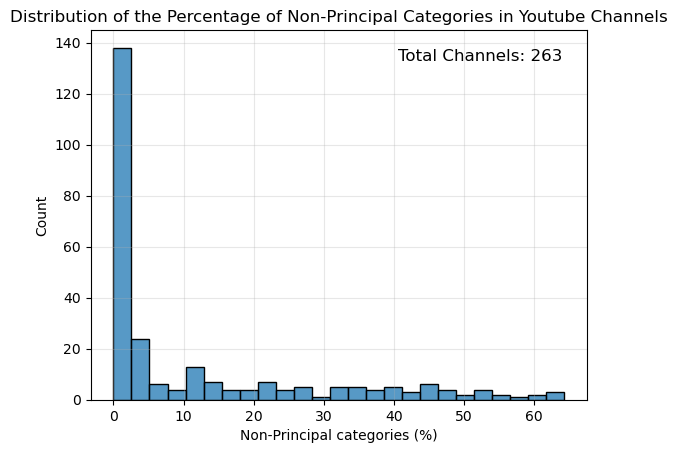


61 % of channels, have less than 5% of Non-Principal Content
37 % of channels, have 0% of Non-Principal Content



In [19]:

# Function that returns the percentage of non principal category videos in a channel
def get_non_principal_category_percentage(dict, channel_id):

    total_video_count = sum(dict[channel_id].values())
    principal_category = max(dict[channel_id], key = dict[channel_id].get)
    non_principal_cat_count = sum(value for cat, value in dict[channel_id].items() if cat != principal_category)

    return 100 * non_principal_cat_count / total_video_count

# function that returns a new dict, with only the channels that have a percentage of non-principal content that is above a threshold
def get_diversified_channels_dict(dict, threshold=20):

    diversified_dict = {}
    for channel_id in dict.keys():
        if get_non_principal_category_percentage(dict, channel_id) > 20:
            diversified_dict[channel_id] = dict[channel_id]

    return diversified_dict
    
def plot_non_principal_category_percentage_distribution(dict):

    list_percentages = [get_non_principal_category_percentage(dict, channel_id) for channel_id in dict.keys()]
    sns.histplot(list_percentages, bins=25)
    plt.text(0.95, 0.95, f"Total Channels: {len(dict)}", ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, color="black")
    plt.title('Distribution of the Percentage of Non-Principal Categories in Youtube Channels')
    plt.xlabel('Non-Principal categories (%)')
    plt.grid(alpha=0.3)
    plt.show()

    # Percentage of channels with less than 5% percent of non-principal content
    p1 = 100*sum(1 for p in list_percentages if p < 5)/len(list_percentages)

    # Percentage of channels with 0 non-principal content
    p2 = 100*sum(1 for p in list_percentages if p == 0)/len(list_percentages)

    print(f'\n{round(p1)} % of channels, have less than 5% of Non-Principal Content')
    print(f'{round(p2)} % of channels, have 0% of Non-Principal Content\n')

plot_non_principal_category_percentage_distribution(dict)    

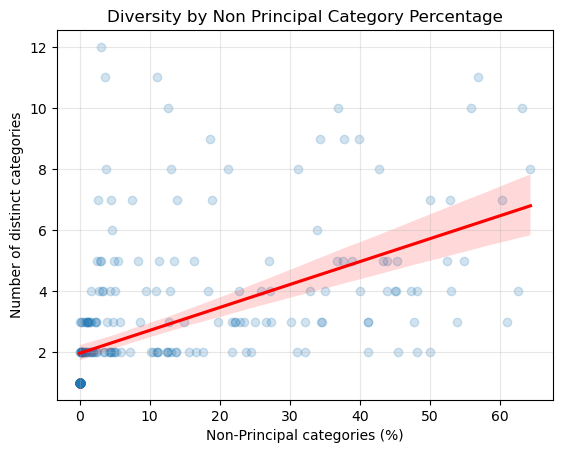

In [20]:
def plot_diversity_by_non_principal_category_percentage(dict):

    channel_id_list = dict.keys()

    list_percentages = [get_non_principal_category_percentage(dict, channel_id) for channel_id in channel_id_list]
    distinct_category_list = [sum(value > 0 for value in dict[channel_id].values()) for channel_id in channel_id_list]

    # Création du nuage de points avec transparence
    plt.scatter(list_percentages, distinct_category_list, alpha=0.2)

    # Ajout de la régression linéaire avec Seaborn
    sns.regplot(x=list_percentages, y=distinct_category_list, scatter=False, color='red', line_kws={"color": "red"})

    plt.grid(alpha=0.3)
    plt.xlabel("Non-Principal categories (%)")
    plt.ylabel("Number of distinct categories")
    plt.title("Diversity by Non Principal Category Percentage")
    plt.show()

plot_diversity_by_non_principal_category_percentage(dict)

### Classification of the Diversity of Youtube Channels

We can create a classification of the diversity of channels (with three classes)

**Not Diversified** - channels with **more than 90%** of content in one category

**Moderately Diversified** - channels with **less than 90%** of content in its principal category

**Diversified** - channels with **less than 90%** of content in its principal category and at **least three different category**


C:\Users\redou\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


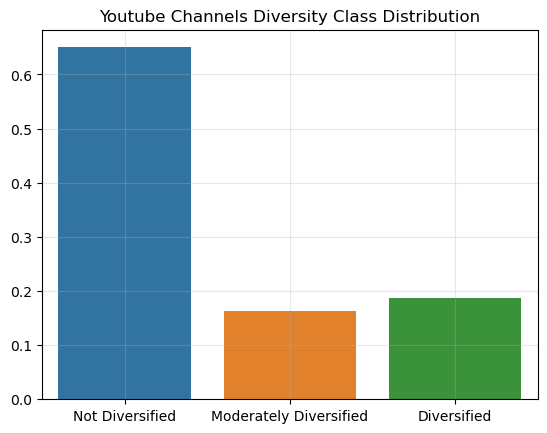

In [23]:

# return the diversity class code : 1 for not diversified, .., 3 for diversified
def get_diversity_class(dict, channel_id):

    class_code = 2
    total_video_count = sum(dict[channel_id].values())
    distinct_category_count = sum(value > 0 for value in dict[channel_id].values())
    is_first_class = False

    for count in dict[channel_id].values():
        if count/total_video_count > 0.90:
            class_code = 1
            is_first_class = 1

    if not is_first_class:
        if distinct_category_count > 3:
            class_code = 3

    return class_code

# Function that plot the Diversity class distribution
def plot_diversity_class_distribution(dict):

    first_class_count, second_class_count, third_class_count = 0, 0, 0

    total_channel_count = len(dict.keys())

    for channel_id in dict.keys():

        class_code = get_diversity_class(dict, channel_id)

        if class_code == 1:
            first_class_count+=1
        if class_code == 2:
            second_class_count+=1
        if class_code == 3:
            third_class_count+=1

    data = {
    'Class': ['Not Diversified', 'Moderately Diversified', 'Diversified'],
    'Percentage': [first_class_count/total_channel_count, second_class_count/total_channel_count, third_class_count/total_channel_count]
    }

    sns.barplot(x='Class', y='Percentage', data=data)
    plt.grid(alpha=0.3)
    plt.title('Youtube Channels Diversity Class Distribution')
    plt.show()

plot_diversity_class_distribution(dict)


C:\Users\redou\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


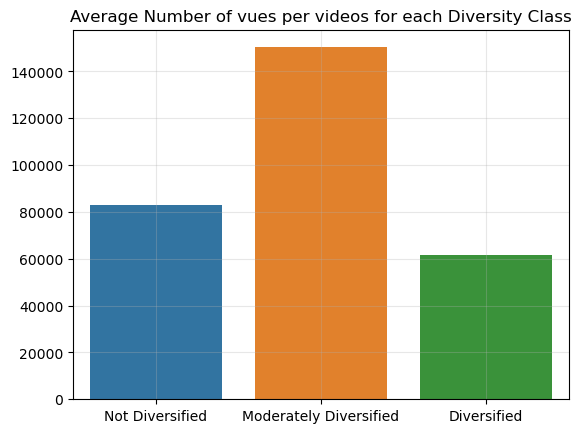

In [24]:
# Average number of views for each class.

def get_mean_vues(df, channel_id_list):

    mean_vues = 0

    count = 0
    channel_id_hash_set = set(channel_id_list)
    
    for index in range(len(df)):
        if df.iloc[index]['channel_id'] in channel_id_hash_set:
            mean_vues += df.iloc[index]['view_count']
            count += 1

    return mean_vues/count

def plot_vues_by_class(df, dict):

    channel_id_list = dict.keys()

    not_diversified_channels = [channel_id for channel_id in channel_id_list if get_diversity_class(dict, channel_id) == 1]
    moderately_diversified_channels = [channel_id for channel_id in channel_id_list if get_diversity_class(dict, channel_id) == 2]
    diversified_channels = [channel_id for channel_id in channel_id_list if get_diversity_class(dict, channel_id) == 3]

    not_diversified_mean_vues = get_mean_vues(df, not_diversified_channels)
    moderately_diversified_mean_vues = get_mean_vues(df, moderately_diversified_channels)
    diversified_mean_vues = get_mean_vues(df, diversified_channels)

    data = {
    'Class': ['Not Diversified', 'Moderately Diversified', 'Diversified'],
    'Average vues': [not_diversified_mean_vues, moderately_diversified_mean_vues, diversified_mean_vues]
    }

    sns.barplot(x='Class', y='Average vues', data=data)
    plt.grid(alpha=0.3)
    plt.title('Average Number of vues per videos for each Diversity Class')
    plt.show()

plot_vues_by_class(df, dict)

**Let's define a metric of diversity score**

In [26]:
def get_basic_diversity_score(video_category_distribution_dict, channel_id):
    score = 0

    for value in video_category_distribution_dict[channel_id].values():
        if value > 0:
            score += 1

    return score

In [27]:
def get_threshold_diversity_score(video_category_distribution_dict, channel_id, treshold):

    video_cat_dist = video_category_distribution_dict[channel_id]
    total_video_number = sum([value for value in video_cat_dist.values()])

    score = 0

    for value in video_cat_dist.values():
        if (value > int(total_video_number * treshold)):
            score += 1

    return score

**Weighted Score : Normalized Entropy**

$C$ is the number of caterories
, $p_i$ the proportion of videos that are in the category $i$.


$$Score(p_1, ...,p_C) = - \frac{\sum _{i}^{C} p_i log (p_i)}{log(C)}$$

In [29]:
def get_weighted_diversity_score(video_category_distribution_dict, channel_id):

    video_cat_dist = video_category_distribution_dict[channel_id]
    total_video_number = sum([value for value in video_cat_dist.values()])

    C = len(video_cat_dist)
    score = 0

    for value in video_cat_dist.values():
        p = value/total_video_number
        if p != 0:
            score = score + (p * np.log(p)) # to avoid log(0)
        
    return - score / np.log(C)

In [30]:
print('Diversity score using entropy formula :',get_weighted_diversity_score(dict, channel_id = 'UCzzzrOhp92PkGrIwGH3_EEg').round(3))

Diversity score using entropy formula : 0.172


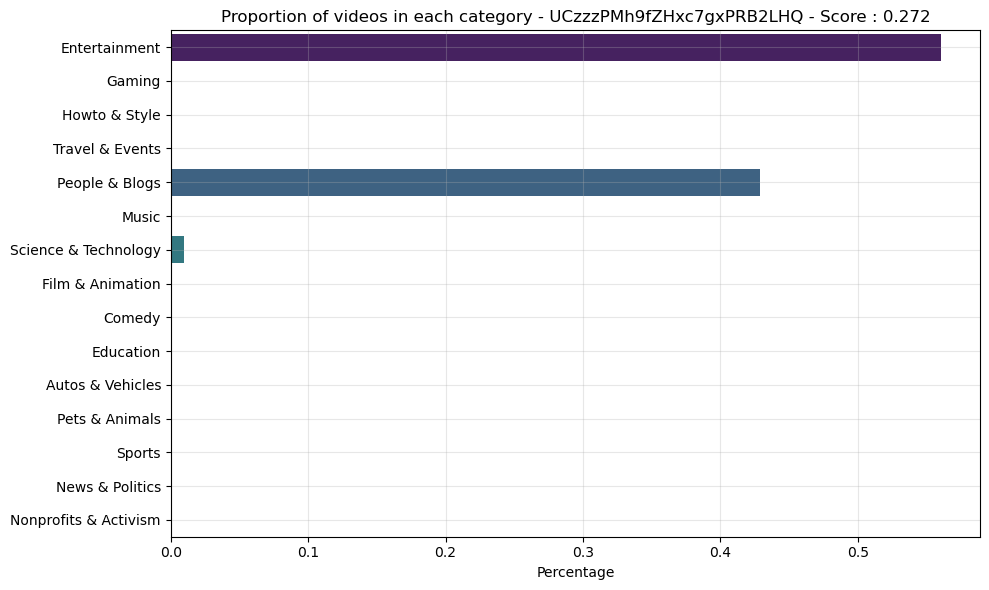

In [31]:
# This function uses the weighted diversity score
def plot_channel_videos_distribution(video_category_distribution_dict, channel_id):

    # Convert the value into proportions
    data = video_category_distribution_dict[channel_id].copy()
    total_video_number = sum([value for value in data.values()])
    for cat in data.keys():
        data[cat] = data[cat] / total_video_number
        
    df = pd.DataFrame(list(data.items()), columns=['Category', 'Video Count'])
    score = get_weighted_diversity_score(video_category_distribution_dict, channel_id)

    plt.figure(figsize=(10, 6))
    sns.barplot(y='Category', x='Video Count', data=df, palette='viridis')
    
    plt.xticks(rotation=90)
    plt.title(f'Proportion of videos in each category - {channel_id} - Score : {score.round(3)}')
    plt.xlabel('Percentage')
    plt.xticks(rotation=0)
    plt.ylabel('')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

plot_channel_videos_distribution(dict, 'UCzzzPMh9fZHxc7gxPRB2LHQ')

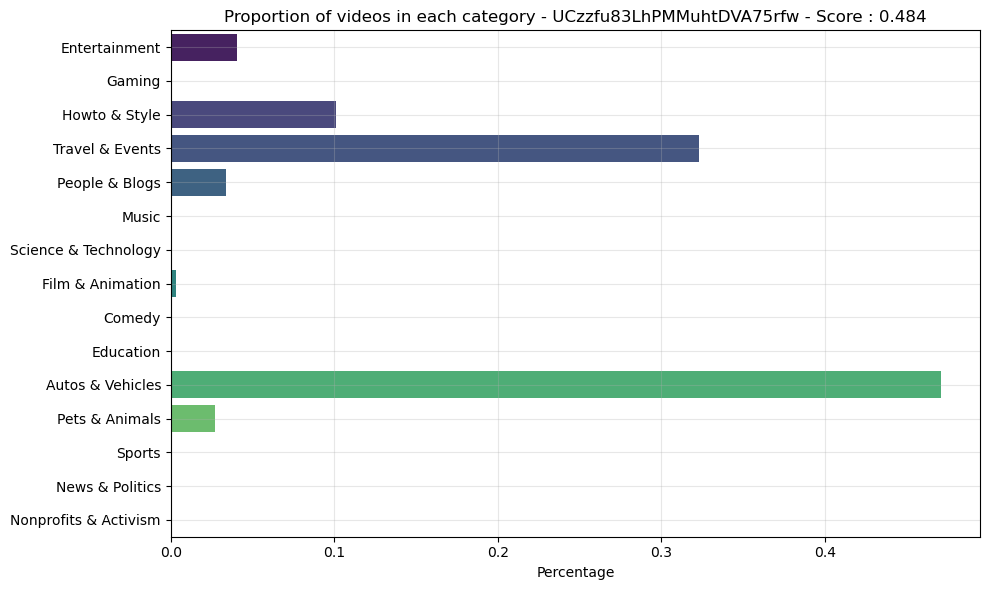

In [32]:
plot_channel_videos_distribution(dict, 'UCzzfu83LhPMMuhtDVA75rfw')

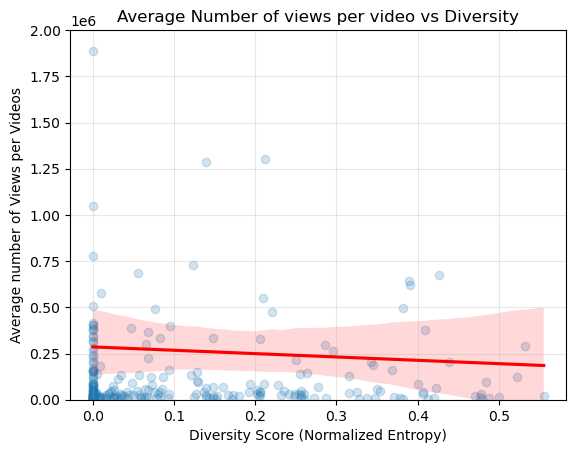

In [33]:
# returns the dictionnary associatin channel_id with the average number of vues in videos
def get_mean_vues_per_video_dict(df, dict):

    dictionnary = {channel_id : [0, 0] for channel_id in dict.keys()}

    for index in range(len(df)):
        dictionnary[df.iloc[index]['channel_id']][0] += df.iloc[index]['view_count']
        dictionnary[df.iloc[index]['channel_id']][1] += 1

    return {key : value[0]/value[1] for key, value in dictionnary.items()}
    
# Function that display the graph of the average number of views for each video of a channel vs the weighted diversity score
def plot_views_vs_diversity(df, dict):

    channel_id_list = dict.keys()

    diversity_scores = [get_weighted_diversity_score(dict, channel_id) for channel_id in channel_id_list]

    mean_vues_dict = get_mean_vues_per_video_dict(df, dict)
    vues_per_channels = [mean_vues_dict[channel_id] for channel_id in channel_id_list]

    # Création du nuage de points avec transparence
    plt.scatter(diversity_scores, vues_per_channels, alpha=0.2)

    # Ajout de la régression linéaire avec Seaborn
    sns.regplot(x=diversity_scores, y=vues_per_channels, scatter=False, color='red', line_kws={"color": "red"})
    plt.grid(alpha=0.3)
    plt.ylim(0, 0.2 * 1e7)
    plt.xlabel("Diversity Score (Normalized Entropy)")
    plt.ylabel("Average number of Views per Videos")
    plt.title("Average Number of views per video vs Diversity")
    plt.show()
    
plot_views_vs_diversity(df, dict)
    

# Distances between youtube channels categories

we can define a **link strength** between categories. 

**First idea** : we can define the link strength between cat1 and cat2 by the number of time a channel has already create one video of each category

to compute this link strength, we can create a dictionnary, dict['Gaming']['Entertainment'] = link strength between 'Gaming' and 'Entertainment'

in fact, link strenght = the number of **co-occurences** of two categories.


In [38]:

# Function that returns a dictionnary : dict['cat1']['cat2'] = co-occurence(cat1, cat2)
def get_link_strength_dict(data, video_category_distribution_dict, categories_list):

    link_strength_dict = {category : {category : 0 for category in categories_list} for category in categories_list}

    channels_id_list = get_unique_values(data, 'channel_id')

    for cat_dist in video_category_distribution_dict.values():
        for cat1 in categories_list:
            for cat2 in categories_list:
                if cat_dist[cat1] and cat_dist[cat2]:
                    link_strength_dict[cat1][cat2] += 1

    return link_strength_dict

In [39]:

# function that displays the dataframe associated with the dictionnary.
def display_link_strength(data, video_category_distribution_dict, category_list):

    link_strength_dict = get_link_strength_dict(data, video_category_distribution_dict, category_list)
    df = pd.DataFrame(link_strength_dict).astype(int)

    return df
    

In [40]:
display_link_strength(df, dict, categories_list)

,Entertainment,Gaming,Howto & Style,Travel & Events,People & Blogs,Music,Science & Technology,Film & Animation,Comedy,Education,Autos & Vehicles,Pets & Animals,Sports,News & Politics,Nonprofits & Activism
Entertainment,99,28,26,21,57,35,18,33,23,30,13,11,17,17,6
Gaming,28,66,12,10,25,9,11,16,12,15,10,4,9,9,2
Howto & Style,26,12,58,15,37,11,20,23,12,18,12,10,9,6,1
Travel & Events,21,10,15,30,24,6,10,14,12,16,10,9,13,9,3
People & Blogs,57,25,37,24,117,31,24,40,23,30,20,15,19,17,7
Music,35,9,11,6,31,90,8,13,7,13,5,5,10,10,3
Science & Technology,18,11,20,10,24,8,37,16,9,19,12,7,11,7,2
Film & Animation,33,16,23,14,40,13,16,58,16,19,12,9,11,10,5
Comedy,23,12,12,12,23,7,9,16,34,12,7,6,10,8,4
Education,30,15,18,16,30,13,19,19,12,53,12,10,15,15,8


**Two ideas to compute the distance between categories**

$A_i$ and $B_i$ are the frequencies of categories $A$ and $B$ in channel $i$

$$\text{Cosine Similarity}(A, B) = \frac{\sum_{i=1}^{C} A_i \cdot B_i}{\sqrt{\sum_{i=1}^{C} A_i^2} \cdot \sqrt{\sum_{i=1}^{C} B_i^2}}$$

$S_A$ is the set of channels where category $A$ appears,
$S_B$ is the set of channels where category $B$ appears,

$|S_A \cap S_B|$  is the size of the intersection of the sets $S_A$ and $S_B$,

$|S_A \cup S_B|$  is the size of the union of the sets $S_A$ and $S_B$,

$$\text{Jaccard Similarity}(A, B) = \frac{|S_A \cap S_B|}{|S_A \cup S_B|}$$

In [42]:
def jaccard_similarity(cat1, cat2, video_category_distribution_dict):

    intersection = 0
    union = 0

    for dict in video_category_distribution_dict.values():
        if dict[cat1] and dict[cat2]:
            intersection+=1
        if dict[cat1] or dict[cat2]:
            union+=1

    if union == 0:
        return 0
    
    return intersection/union
    

In [43]:
def cosine_similarity(cat1, cat2, video_category_distribution_dict):

    result, n1, n2 = 0, 0, 0

    for dict in video_category_distribution_dict.values():
        result += dict[cat1]*dict[cat2]
        n1 += dict[cat1]**2
        n2 += dict[cat2]**2

    return result / (np.sqrt(n1) * np.sqrt(n2))

In [44]:
cosine_similarity('Music', 'Entertainment', dict)

0.004942308220501331

In [45]:
jaccard_similarity('Music', 'Entertainment', dict)

0.22727272727272727

In [46]:

def display_similarity(data, video_category_distribution_dict, categories_list, similarity_function):

    similarity_dict = {cat : {cat : 0 for cat in categories_list} for cat in categories_list}
    for cat1 in categories_list:
        for cat2 in categories_list:
            similarity_dict[cat1][cat2] = similarity_function(cat1, cat2, video_category_distribution_dict)
        
    df = pd.DataFrame(similarity_dict)

    return df


In [47]:

def plot_heatmap(df):
    # Créer la heatmap avec Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Similarity'})
    plt.title('Category Similarity Heatmap')
    plt.show()
    

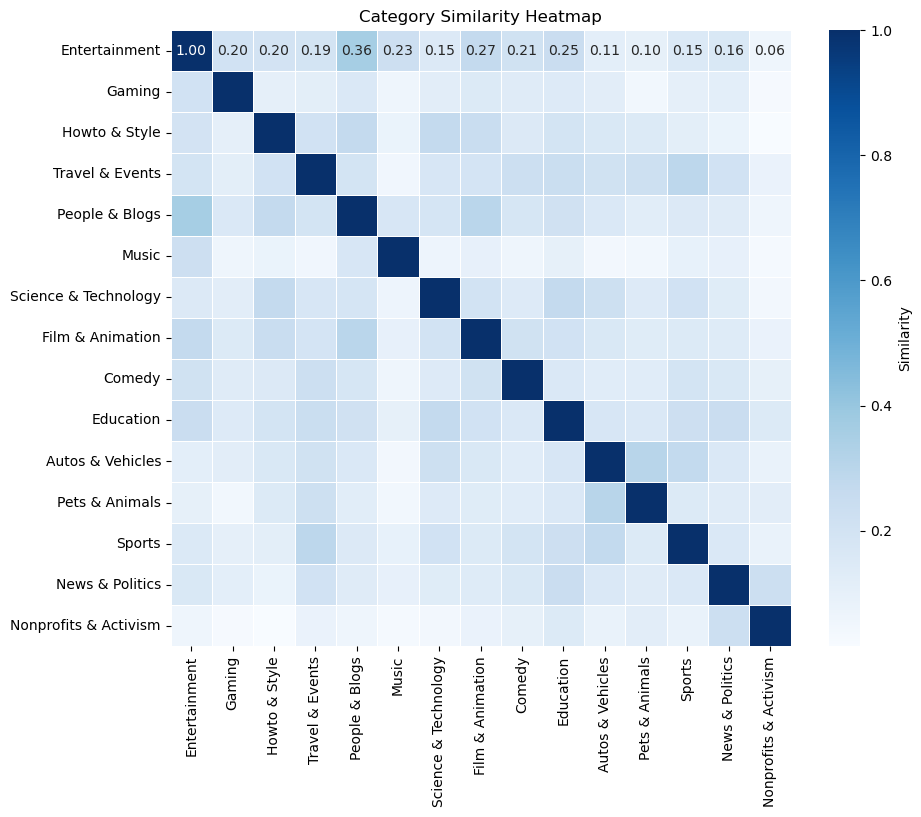

In [48]:
plot_heatmap(display_similarity(df, dict, categories_list, jaccard_similarity))

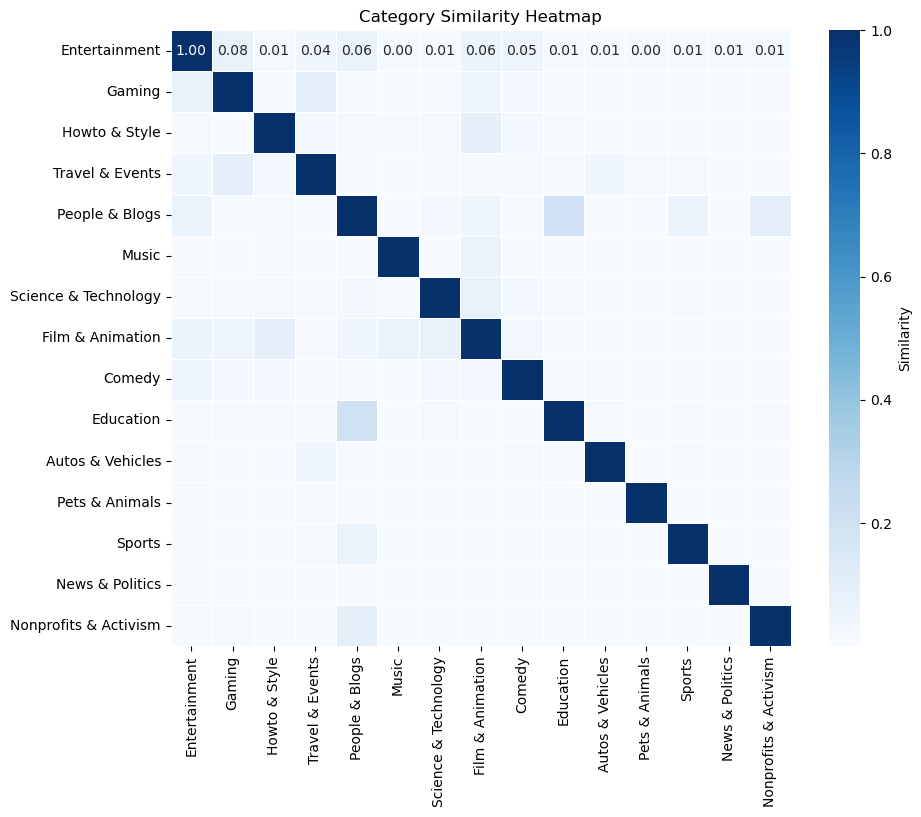

In [49]:
plot_heatmap(display_similarity(df, dict, categories_list, cosine_similarity))

**Problem**: We want to identify YouTube video categories that often appear together on creators' channels. However, the metrics we’re currently using face challenges in accurately capturing this, partly due to noise from small numbers of videos and differences in how categories are distributed. Here are two specific limitations:

Jaccard Similarity: This metric doesn’t effectively distinguish between channels that focus mainly on one category versus those with a more balanced mix. For example, a channel with 49 "gaming" videos and just 1 "sports" video would have the same Jaccard similarity between "gaming" and "sports" as a channel with 25 "gaming" and 25 "sports" videos, since Jaccard only considers whether each category is present or not. This makes it hard to capture the real connection between categories.

Cosine Similarity: This metric is also insensitive to differences in video counts between categories. For example, a channel with 50 "gaming" and 50 "music" videos could show the same cosine similarity between "gaming" and "music" as a channel with just 1 video in each category. This focus on relative proportions, instead of the actual counts, makes it harder to measure how strongly categories are paired.

**Solutions**:


To fix Jaccard Similarity problem, we can define :
Weighted Jaccard Similarity as following 
$$
\text{Weighted Jaccard Similarity}(A, B) = \frac{\sum_i \min(A_i, B_i)}{\sum_i \max(A_i, B_i)}
$$

where $A_i$ and $B_i$ represents the numbers of occurences of category $A$ and $B$ for the channel $i$.


In [53]:
def weighted_jaccard_similarity(cat1, cat2, video_category_distribution_dict):

    intersection_sum = 0
    union_sum = 0
    
    for counts in video_category_distribution_dict.values():
        count_cat1 = counts.get(cat1, 0)
        count_cat2 = counts.get(cat2, 0)

        intersection_sum += min(count_cat1, count_cat2)
        union_sum += max(count_cat1, count_cat2)
    
    if union_sum == 0:
        return 0
    
    return intersection_sum / union_sum


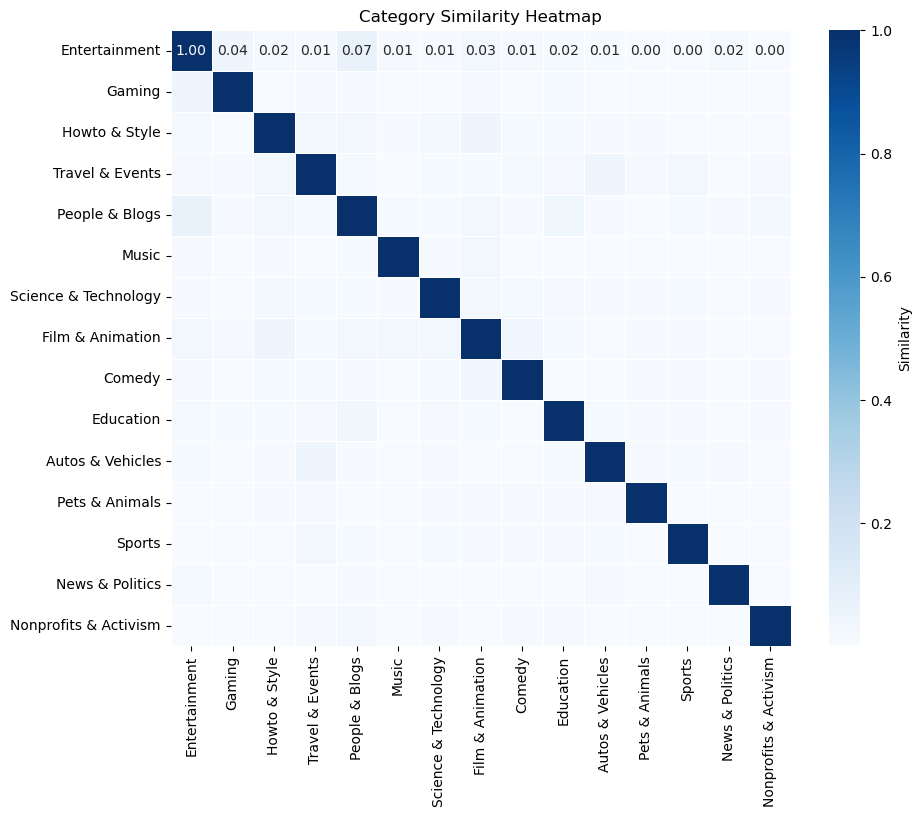

In [54]:
plot_heatmap(display_similarity(df, dict, categories_list, weighted_jaccard_similarity))

To fix the issue of noise caused by categories with few occurrences, we can filter out these categories by setting a threshold based on the percentage of a category's presence in a channel before it is considered.

In [56]:

'''This function returns a new filtered dictionnary
each category with less than a treshold percentage of appearance in a channel is ignored.'''

def filter_categories_by_threshold(dict, threshold=0.1):

    filtered_dict = copy.deepcopy(dict)

    for channel, category_data in filtered_dict.items():
        total_videos = sum(category_data.values())  
        if total_videos == 0:
            continue  
        

        for category, count in category_data.items():
            proportion = count / total_videos 
            if proportion < threshold:
                category_data[category] = 0  
                
    return filtered_dict


In [57]:
dict['UCzzfu83LhPMMuhtDVA75rfw']

{'Entertainment': 12,
 'Gaming': 0,
 'Howto & Style': 30,
 'Travel & Events': 96,
 'People & Blogs': 10,
 'Music': 0,
 'Science & Technology': 0,
 'Film & Animation': 1,
 'Comedy': 0,
 'Education': 0,
 'Autos & Vehicles': 140,
 'Pets & Animals': 8,
 'Sports': 0,
 'News & Politics': 0,
 'Nonprofits & Activism': 0}

In [58]:
filtered_dict = filter_categories_by_threshold(dict, threshold = 0.1)
filtered_dict['UCzzfu83LhPMMuhtDVA75rfw']

{'Entertainment': 0,
 'Gaming': 0,
 'Howto & Style': 30,
 'Travel & Events': 96,
 'People & Blogs': 0,
 'Music': 0,
 'Science & Technology': 0,
 'Film & Animation': 0,
 'Comedy': 0,
 'Education': 0,
 'Autos & Vehicles': 140,
 'Pets & Animals': 0,
 'Sports': 0,
 'News & Politics': 0,
 'Nonprofits & Activism': 0}

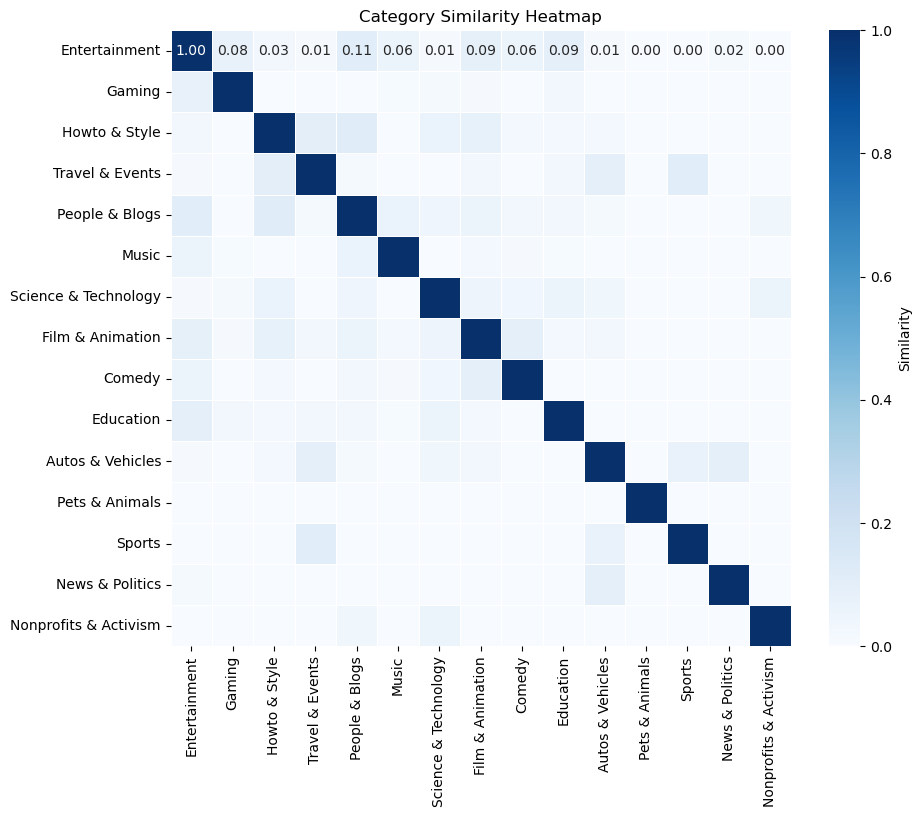

In [59]:
plot_heatmap(display_similarity(df, filtered_dict, categories_list, jaccard_similarity))

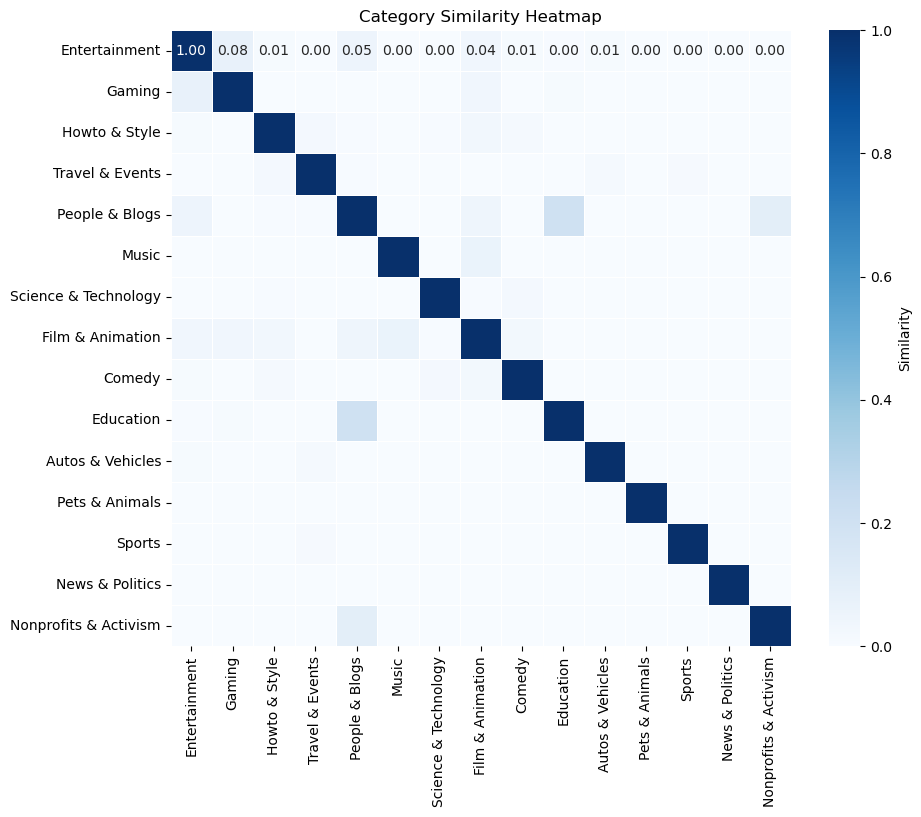

In [60]:
plot_heatmap(display_similarity(df, filtered_dict, categories_list, cosine_similarity))

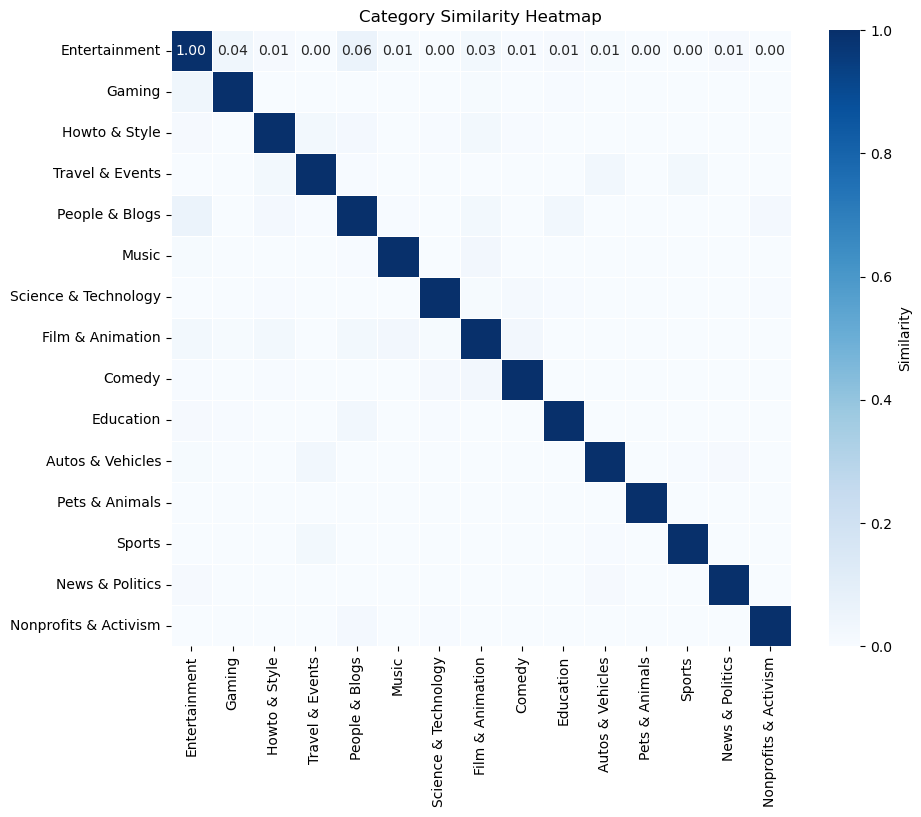

In [61]:
plot_heatmap(display_similarity(df, filtered_dict, categories_list, weighted_jaccard_similarity))

## Correlation avec le nombre d'abonnés, vues & graphe sur la diversité 

In [63]:
# dictionnary of channels with more than 20% of content that isn't in the principal-category
diversified_dict = get_diversified_channels_dict(dict, threshold=0)
diversified_ids = diversified_dict.keys()
df_filtered = df[df['channel_id'].isin(diversified_ids)]

In [64]:
def calculate_average_views(df_filtered):
    average_views = df_filtered.groupby(['channel_id', 'categories'])['view_count'].mean().reset_index()
    video_count = df_filtered.groupby(['channel_id', 'categories']).size().reset_index(name='video_count')
    max_video_count = video_count.groupby('channel_id')['video_count'].max().reset_index()
    max_video_count = max_video_count.rename(columns={'video_count': 'max_video_count'})
    video_count = video_count.merge(max_video_count, on='channel_id')
    video_count['most_category'] = video_count['video_count'] == video_count['max_video_count']
    average_views = average_views.merge(video_count[['channel_id', 'categories', 'most_category']], on=['channel_id', 'categories'], how='left')
    return average_views


def plot_category_percentage(average_views):
    max_view_category = average_views.loc[average_views.groupby('channel_id')['view_count'].idxmax()]
    max_view_category['same_category'] = max_view_category['most_category']
    percent_same_category = max_view_category['same_category'].mean() * 100

    plt.figure(figsize=(8, 6))
    sns.barplot(x=['Same category', 'Other category'], y=[percent_same_category, 100 - percent_same_category])
    plt.title("Percentage of channels where the most represented category is also the one with the most views")
    plt.ylabel("Percentage")
    plt.grid(alpha=0.3)
    plt.show()

In [65]:
average_views = calculate_average_views(df_filtered)

In [66]:
first_youtuber = average_views['channel_id'].iloc[0]
example_youtuber = average_views[average_views['channel_id'] == first_youtuber]
print(example_youtuber)

                 channel_id        categories    view_count  most_category
0  UCzuFRkWj9156yqVO8eat0LA            Comedy  28526.500000          False
1  UCzuFRkWj9156yqVO8eat0LA         Education   9937.000000          False
2  UCzuFRkWj9156yqVO8eat0LA     Entertainment   2342.600000          False
3  UCzuFRkWj9156yqVO8eat0LA  Film & Animation   2491.533333          False
4  UCzuFRkWj9156yqVO8eat0LA            Gaming    926.000000          False
5  UCzuFRkWj9156yqVO8eat0LA     Howto & Style  10430.333333          False
6  UCzuFRkWj9156yqVO8eat0LA    People & Blogs   2660.555556          False
7  UCzuFRkWj9156yqVO8eat0LA            Sports   5305.368715           True
8  UCzuFRkWj9156yqVO8eat0LA   Travel & Events   7261.275862          False


C:\Users\redou\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


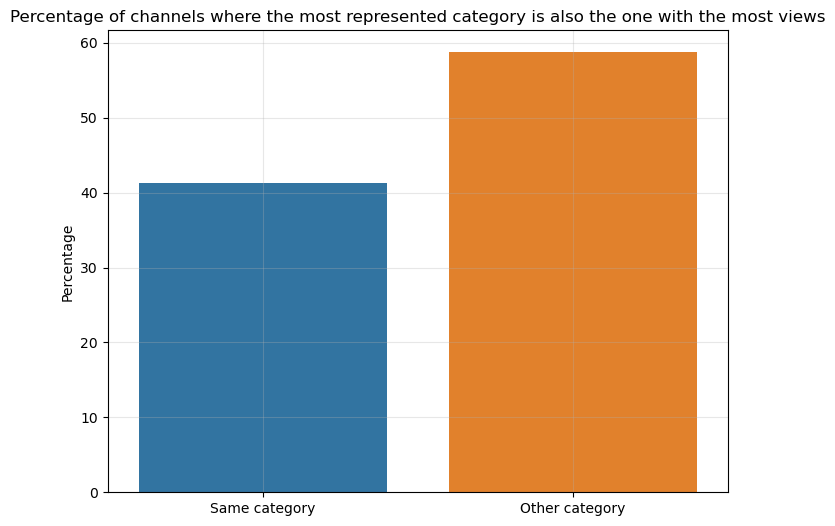

In [67]:
plot_category_percentage(average_views)

# Space representation of the categories

Knowing the area of each category, wich is the number of occurence of each category and the, area of the intersection of each couple of category, wich is the number of co-occurences we can draw a spacial representation of the categories.

In [70]:
category_colors = {
    'Film and Animation': '#4C72B0',   # Soft Blue
    'Entertainment': '#DD8452',         # Warm Orange
    'Music': '#55A868',                 # Soft Green
    'Comedy': '#C44E52',                # Deep Red
    'Gaming': '#8172B2',                # Muted Purple
    'Science & Technology': '#8C564B',  # Warm Brown
    'Sports': '#E377C2',                # Vibrant Pink
    'Education': '#7F7F7F',             # Neutral Grey
    'People & Blogs': '#BCBD22',        # Fresh Yellow-green
    'Nonprofits & Activism': '#17BECF', # Cool Light Blue
    'Howto & Style': '#FFB74D',         # Light Orange
    'News & Politics': '#F28E2B',       # Bold Red-Orange
    'Travel & Events': '#C5B0D5',       # Lavender Purple
    'Autos & Vehicles': '#9E7C4D',      # Earthy Tan
    'Pets & Animals': '#F7B6D2'         # Soft Light Pink
}

C:\Users\redou\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\redou\AppData\Local\Temp\ipykernel_15036\2700926461.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s=sizes[i] * 10,  # Adjust size scaling here if needed


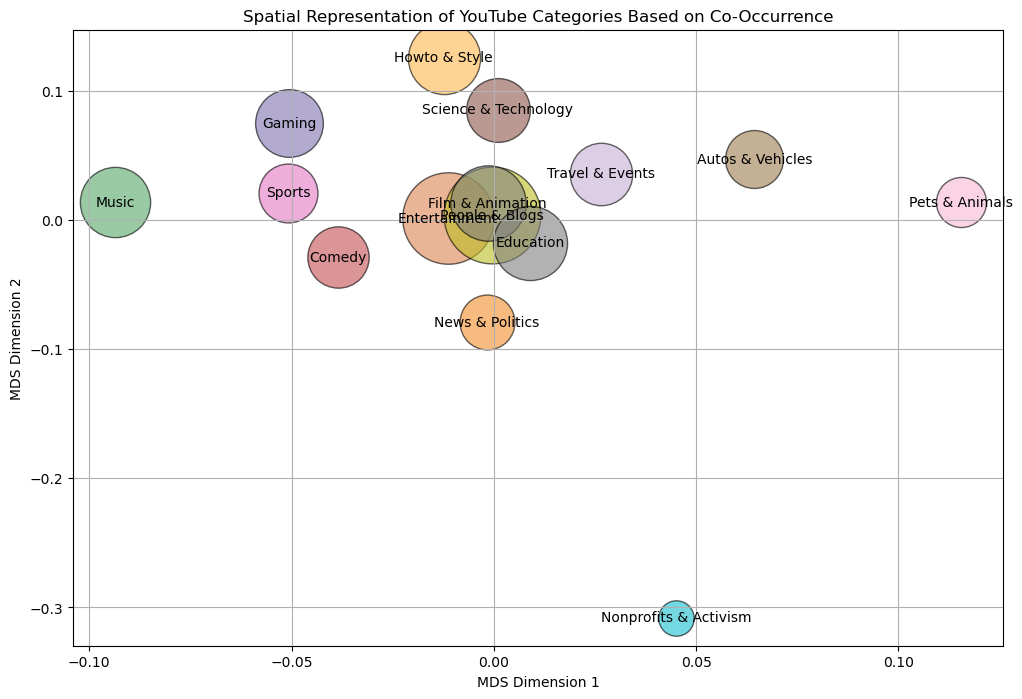

In [71]:
from sklearn.manifold import MDS

df_link_strength = pd.DataFrame(get_link_strength_dict(df, dict, categories_list))

# Calculate sizes for each category based on sum of co-occurrences
sizes = df_link_strength.sum(axis=1)

# Apply MDS for 2D representation
mds = MDS(n_components=2, random_state=0, dissimilarity="precomputed")
distance_matrix = 1 / (df_link_strength + 1e-5)
coords = mds.fit_transform(distance_matrix)

# Plot with customized colors and sizes
plt.figure(figsize=(12, 8))

# Plot each category with its associated color and size
for i, category in enumerate(df_link_strength.columns):
    plt.scatter(coords[i, 0], coords[i, 1],
                s=sizes[i] * 10,  # Adjust size scaling here if needed
                color=category_colors.get(category, 'grey'),  # Get color from dict or default to grey
                edgecolor='black',  # Outline color for distinction
                alpha=0.6)  # Adjust transparency for overlap visibility
    plt.text(coords[i, 0], coords[i, 1], category, fontsize=10, ha='center', va='center')

# Titles and labels
plt.title("Spatial Representation of YouTube Categories Based on Co-Occurrence")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.show()